# 1. Imports

In [1]:
from build_model import build_v2g_model_multinomial, evaluate_subset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import itertools
from sklearn.model_selection import cross_val_score

# 2. Model setup

In [2]:
## For the input variables:

'''

Q9 - How familiar are you with the term Vehicle-to-Grid (V2G) (also known as bidirectional charging)?
Q2 - Approximately how many kilometres do you drive per year?
Q8 - Which of the following do you currently have at your home? 
(Q8 is broken down as:)
    Q8_1 - Solar panels 
    Q8_2 - Home battery
    Q8_99 - Neither



'''

'\n\nQ9 - How familiar are you with the term Vehicle-to-Grid (V2G) (also known as bidirectional charging)?\nQ2 - Approximately how many kilometres do you drive per year?\nQ8 - Which of the following do you currently have at your home? \n(Q8 is broken down as:)\n    Q8_1 - Solar panels \n    Q8_2 - Home battery\n    Q8_99 - Neither\n\n\n\n'

In [3]:
input_variables = [
    'Q1_1',
    'Q1_2',
    'Q1_3',
    'Q1_4',
    'Q1_99',
    'Q9',
    'Q2',
    'Q8_1',
    'Q8_2',
    'Q8_99'
    ]


target_variable = 'Q10_2'  # "I would be interested in installing V2G..."
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

input_variables_names = [
    'Owns Petrol/Diesel car',
    'Owns Electric vehicle',
    'Plug-in Hybrid vehicle',
    'Hybrid vehicle',
    'I don’t own a car',
    'How familiar are you with V2G?',
    'Do you own an EV'
    'How many kilometres do you drive per year?',
    'Owns Solar Panels',
    'Owns Home battery',
    'Owns neither Solar nor Battery'
]

# 3. Model run

In [5]:
model, X, y, X_test, y_test = build_v2g_model_multinomial(csv_file, input_variables, target_variable, do_normalize=True, test_split_ratio=0.0)

Train accuracy: 0.47232472324723246


In [6]:
'''
Each cell is the coefficient that the logistic regression model uses to estimate the “log-odds” of that class, relative to a baseline in a multinomial setting. 
In scikit‐learn’s multinomial logistic regression, each row’s coefficients reflect how that feature (column) pushes the model toward or away from that particular class.

'''

'\nEach cell is the coefficient that the logistic regression model uses to estimate the “log-odds” of that class, relative to a baseline in a multinomial setting. \nIn scikit‐learn’s multinomial logistic regression, each row’s coefficients reflect how that feature (column) pushes the model toward or away from that particular class.\n\n'

In [10]:
input_variables_names

['Owns Petrol/Diesel car',
 'Owns Electric vehicle',
 'Plug-in Hybrid vehicle',
 'Hybrid vehicle',
 'I don’t own a car',
 'How familiar are you with V2G?',
 'Do you own an EVHow many kilometres do you drive per year?',
 'Owns Solar Panels',
 'Owns Home battery',
 'Owns neither Solar nor Battery']

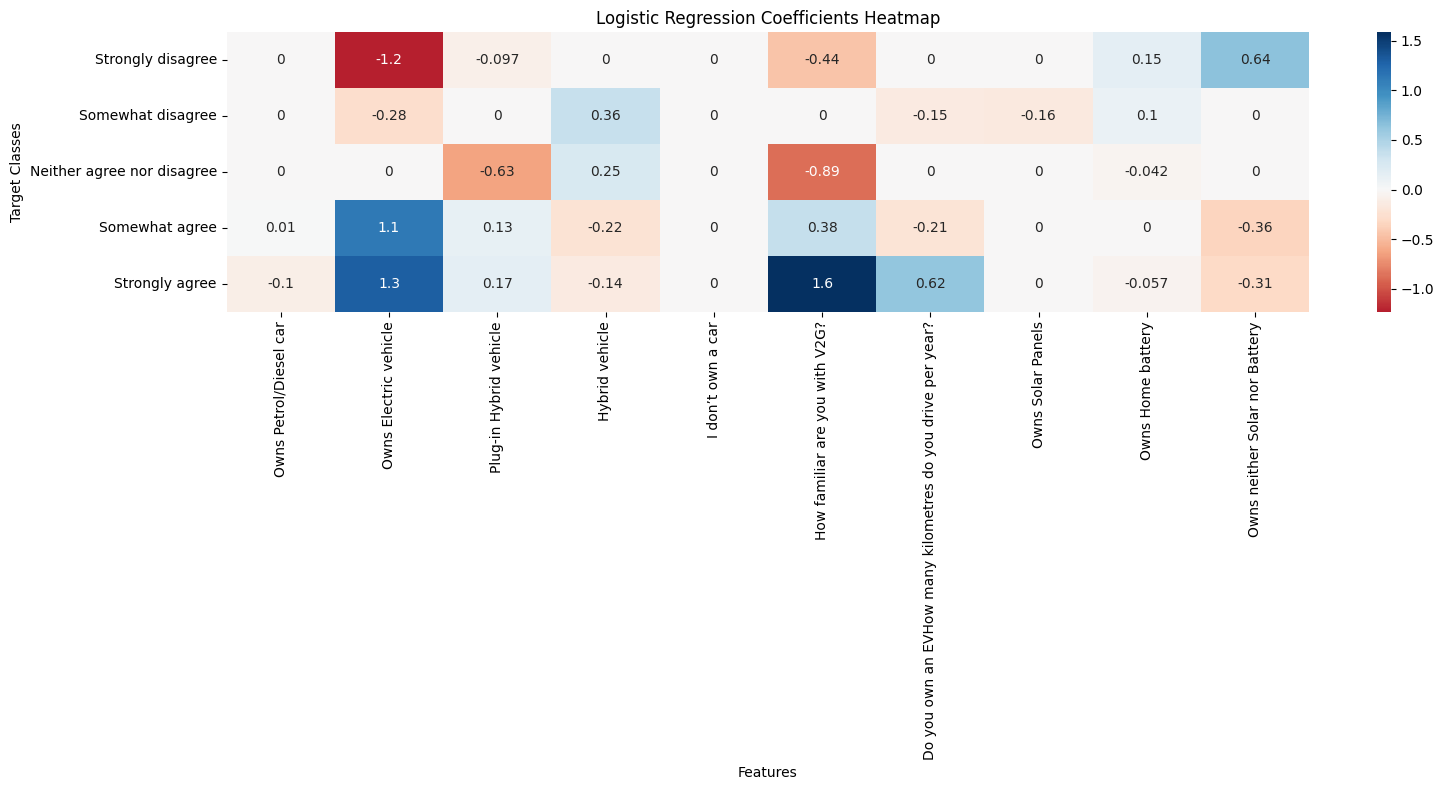

In [7]:
coefs = model.coef_  # shape: (n_classes, n_features)

row_labels = q10_2_categories  
col_labels = input_variables_names  

plt.figure(figsize=(16, 8))
sns.heatmap(
    coefs,
    annot=True,        # display numerical values in the cells
    cmap="RdBu",     
    xticklabels=col_labels,
    yticklabels=row_labels,
    center=0           # ensures 0 is in the middle of the color scale
)
plt.title("Logistic Regression Coefficients Heatmap")
plt.xlabel("Features")
plt.ylabel("Target Classes")
plt.tight_layout()
plt.show()

In [ ]:
'''
All else equal, a person with a higher coded value for familiarity with V2G (e.g. ‘Very familiar’ mapped to 3) has a strong push towards ‘Strongly agree’ about installing V2G chargers.

Meanwhile, row 0 (Strongly disagree) for Q9 = -0.44 might appear if the code forced that coefficient negative (or zero). A negative sign would mean that higher familiarity reduces the log-odds of strongly disagreeing.


'''

In [11]:
# Now let's systematically try all combinations of these variables
best_acc = 0
best_combo = None

for r in range(1, len(input_variables) + 1):
    for subset in itertools.combinations(input_variables, r):
        mean_cv_acc = evaluate_subset(csv_file, subset, target_variable)
        if mean_cv_acc > best_acc:
            best_acc = mean_cv_acc
            best_combo = subset

print("Best subset:", best_combo)
print("Best subset accuracy:", best_acc)

Train accuracy: 0.3446244477172312
Train accuracy: 0.4639175257731959
Train accuracy: 0.3446244477172312
Train accuracy: 0.35051546391752575
Train accuracy: 0.3446244477172312
Train accuracy: 0.42341678939617083
Train accuracy: 0.34391143911439115
Train accuracy: 0.390279823269514
Train accuracy: 0.3446244477172312
Train accuracy: 0.3910162002945508
Train accuracy: 0.4639175257731959
Train accuracy: 0.3446244477172312
Train accuracy: 0.3475699558173785
Train accuracy: 0.3446244477172312
Train accuracy: 0.4322533136966127
Train accuracy: 0.3800738007380074
Train accuracy: 0.41531664212076586
Train accuracy: 0.38144329896907214
Train accuracy: 0.41531664212076586
Train accuracy: 0.4639175257731959
Train accuracy: 0.4639175257731959
Train accuracy: 0.4639175257731959
Train accuracy: 0.4639175257731959
Train accuracy: 0.46494464944649444
Train accuracy: 0.4639175257731959
Train accuracy: 0.4639175257731959
Train accuracy: 0.4639175257731959
Train accuracy: 0.35051546391752575
Train accurac

In [12]:
all_variables = [
    # e.g. EVERY column except those we exclude 
    # or just a subset you're testing
    "Q9", "Q2", "Q8_1", "Q8_2", "Q8_99", # ...
    "Q15_1", "Q15_2", # etc.
]

best_acc = 0
best_combo = None
max_subset_size = 5 

for r in range(1, max_subset_size + 1):
    for subset in itertools.combinations(all_variables, r):
        try:
            acc = evaluate_subset(csv_file, subset, target_variable)
            if acc > best_acc:
                best_acc = acc
                best_combo = subset
        except ValueError as e:
            # Probably "No valid rows found" or some parse error
            # We can skip
            pass

print("Best combo:", best_combo)
print("Best accuracy:", best_acc)

Train accuracy: 0.42341678939617083
Train accuracy: 0.34391143911439115
Train accuracy: 0.390279823269514
Train accuracy: 0.3446244477172312
Train accuracy: 0.3910162002945508
Train accuracy: 0.3446244477172312
Train accuracy: 0.38217967599410896
Train accuracy: 0.4236162361623616
Train accuracy: 0.4329896907216495
Train accuracy: 0.422680412371134
Train accuracy: 0.4329896907216495
Train accuracy: 0.42341678939617083
Train accuracy: 0.42930780559646536
Train accuracy: 0.388929889298893
Train accuracy: 0.36309963099631
Train accuracy: 0.3896678966789668
Train accuracy: 0.34391143911439115
Train accuracy: 0.381549815498155
Train accuracy: 0.3910162002945508
Train accuracy: 0.3910162002945508
Train accuracy: 0.390279823269514
Train accuracy: 0.40353460972017674
Train accuracy: 0.3910162002945508
Train accuracy: 0.3446244477172312
Train accuracy: 0.37776141384388806
Train accuracy: 0.3910162002945508
Train accuracy: 0.40427098674521356
Train accuracy: 0.38217967599410896
Train accuracy: 0

In [14]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X)
cm = confusion_matrix(y, y_pred, labels=[1,2,3,4,5])
print(cm)

[[182   0  49   0  48]
 [ 43   0  17   0  35]
 [109   0  59   3 101]
 [ 38   0  20   3 181]
 [ 45   0  23   3 396]]
